# Initialization

##### Imports

In [1]:
import os, shutil, importlib, collections, json
import utils; importlib.reload(utils)

import vgg19; importlib.reload(vgg19)
import vgg16; importlib.reload(vgg16)
from vgg19 import Vgg19
from vgg16 import Vgg16

# os.environ["CUDA_VISIBLE_DEVICES"]=''
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import h5py
import keras
import sklearn

from glob import glob
from PIL import Image
from os.path import join as jp

from keras import models, optimizers, regularizers, applications
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.utils import layer_utils, np_utils
from keras.layers import *
from keras.optimizers import Adam

from scipy import ndimage

from sklearn import metrics
from sklearn.model_selection import train_test_split

from IPython.display import FileLink

%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

Using TensorFlow backend.


##### Struct Dir

In [3]:
path = '../data/fish/'
classes=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
utils.create_dirs(path, classes)

Move imgs into valid and copy 100 per class into sample

In [22]:
for cl in classes:
    imgs = glob(jp(path, 'train', cl, '*.jpg'))
    imgs_train, imgs_valid = train_test_split(imgs, test_size=0.2)
    for img in imgs_valid:
        shutil.move(img, jp(path, 'valid', cl))

Copy 100 of each class into sample

In [25]:
for cl in classes:
    take = 100 if len(glob(jp(path, 'valid', cl, '*.jpg'))) > 100 \
                else len(glob(jp(path, 'valid', cl, '*.jpg')))
    imgs_train = np.random.choice(glob(jp(path, 'train', cl, '*.jpg')), take, replace=False)
    imgs_valid = np.random.choice(glob(jp(path, 'valid', cl, '*.jpg')), take, replace=False)
    for img_tr, img_v in zip(imgs_train, imgs_valid):
        shutil.copy(img_tr, jp(path, 'sample', 'train', cl, img_tr.split('/')[-1]))
        shutil.copy(img_v, jp(path, 'sample', 'valid', cl, img_v.split('/')[-1]))

In [26]:
files = np.random.choice(glob(jp(path, 'test', 'test', '*.jpg')), 100, replace=False)
for img in files:
    shutil.copy(img, jp(path, 'sample', 'test', 'test', img.split('/')[-1]))

# Sample

## Define Paths

In [2]:
# path = '../data/fish/'
path = '../data/fish/sample/'
path_model = '../data/fish/models/'
path_test = path + 'test'
path_train = path + 'train'
path_valid = path + 'valid'
path_img_arrays = path + 'img_arrays/'

path_submit = path_model + 'submissions/'
path_checkpoint = path_model + 'checkpoints/'
path_results = path_model + 'results/'

In [3]:
batch_size = 8

In [4]:
classes, filenames = utils.get_classes(path)
labels_train = classes[2]
labels_valid = classes[3]
filenames_train = [f.split('/')[-1] for f in filenames[0]]
filenames_valid = [f.split('/')[-1] for f in filenames[1]]

Found 467 images belonging to 8 classes.
Found 467 images belonging to 8 classes.
Found 100 images belonging to 1 classes.


## Data

##### Compress

In [5]:
utils.compress_imgs(path_train, path_img_arrays+'train.bc', chunk_size=100)
utils.compress_imgs(path_valid, path_img_arrays+'valid.bc', chunk_size=100)
utils.compress_imgs(path_test, path_img_arrays+'test.bc', chunk_size=100)

Found 467 images belonging to 8 classes.
Saving 5 chunks
[=====>] 467/467 images
Found 467 images belonging to 8 classes.
Saving 5 chunks
[=====>] 467/467 images
Found 100 images belonging to 1 classes.
Saving 1 chunks
[=>] 100/100 images


In [7]:
utils.compress_imgs(path_train, path_img_arrays+'train_l.bc',
                    chunk_size=100, target_size=(360, 640))
utils.compress_imgs(path_valid, path_img_arrays+'valid_l.bc',
                    chunk_size=100, target_size=(360, 640))
# utils.compress_imgs(path_test, path_img_arrays+'test_l.bc', chunk_size=100)

Found 467 images belonging to 8 classes.
Saving 5 chunks
[=====>] 467/467 images
Found 467 images belonging to 8 classes.
Saving 5 chunks
[=====>] 467/467 images


##### Load

Small Images (224, 224)

In [5]:
data_train = utils.load_array_bcolz(path_img_arrays+'train.bc')
data_valid = utils.load_array_bcolz(path_img_arrays+'valid.bc')
# data_test = utils.load_array_bcolz(path_img_arrays+'test.bc')

Large Images (360, 640)

In [5]:
# data_train = utils.load_array_bcolz(path_img_arrays+'train_l.bc')
data_valid = utils.load_array_bcolz(path_img_arrays+'valid_l.bc')
# data_test = utils.load_array_bcolz(path_img_arrays+'test.bc')

##### VGG16 Conv

Small Images

In [6]:
vgg = Vgg16()
layers_conv, layers_fc = utils.split_at(vgg.model, Conv2D)
vgg_conv = models.Sequential(layers_conv)

Loading model weights


In [10]:
data_conv_train = vgg_conv.predict(data_train, batch_size=batch_size, verbose=1)
data_conv_valid = vgg_conv.predict(data_valid, batch_size=batch_size, verbose=1)
data_conv_test = vgg_conv.predict(data_test, batch_size=batch_size, verbose=1)

100/100 [==============================] - 20s    


In [18]:
utils.save_array_bcolz(path_img_arrays+'conv_train.bc', data_conv_train)
utils.save_array_bcolz(path_img_arrays+'conv_valid.bc', data_conv_valid)
utils.save_array_bcolz(path_img_arrays+'conv_test.bc', data_conv_test)

Large Images (360, 640)

In [3]:
vgg = Vgg16(size=(360, 640)).model
vgg.pop()
vgg.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [6]:
data_conv_train = vgg.predict(data_train, batch_size=2, verbose=1)
data_conv_valid = vgg.predict(data_valid, batch_size=2, verbose=1)
# data_conv_test = vgg.predict(data_test, batch_size=2, verbose=1)

467/467 [==============================] - 342s   


In [7]:
utils.save_array_bcolz(path_img_arrays+'conv_train_l.bc', data_conv_train)
utils.save_array_bcolz(path_img_arrays+'conv_valid_l.bc', data_conv_valid)
# utils.save_array_bcolz(path_img_arrays+'conv_test.bc', data_conv_test)

##### Conv Load

Small Images (224, 224)

In [6]:
data_conv_train = utils.load_array_bcolz(path_img_arrays+'conv_train.bc')
data_conv_valid = utils.load_array_bcolz(path_img_arrays+'conv_valid.bc')
# data_conv_test = utils.load_array_bcolz(path_img_arrays+'conv_test.bc')

Large Images (360, 640)

In [5]:
data_conv_train = utils.load_array_bcolz(path_img_arrays+'conv_train_l.bc')
data_conv_valid = utils.load_array_bcolz(path_img_arrays+'conv_valid_l.bc')
# data_conv_test = utils.load_array_bcolz(path_img_arrays+'conv_test.bc')

## Initial Model

##### Finetune VGG batch norm

In [6]:
# vgg = Vgg16(load_weights=True)
vgg = Vgg16(load_weights=False)

In [7]:
vgg.ft(len(np.unique(classes[0])))

In [8]:
layers_conv, layers_fc = utils.split_at(vgg.model, Conv2D)

In [9]:
vgg_fc = utils.create_model_from_layers(layers_fc)
for layer in vgg_fc.layers[:-1]:
    layer.trainable = False

In [27]:
vgg_fc.compile(Adam(lr=1e-3), 'categorical_crossentropy', metrics=['accuracy'])

In [23]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_ft.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
vgg_fc.fit(data_conv_train, labels_train, batch_size=batch_size,
           nb_epoch=4, callbacks=callbacks,
           validation_data=(data_conv_valid, labels_valid))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 17s - loss: 2.0789 - acc: 0.4668 - val_loss: 1.3862 - val_acc: 0.5846
Epoch 2/4
467/467 [==============================] - 14s - loss: 1.3751 - acc: 0.5824 - val_loss: 1.3893 - val_acc: 0.5824
Epoch 3/4
467/467 [==============================] - 16s - loss: 1.2817 - acc: 0.6467 - val_loss: 1.2623 - val_acc: 0.6617
Epoch 4/4
467/467 [==============================] - 14s - loss: 1.1277 - acc: 0.6638 - val_loss: 1.5331 - val_acc: 0.6338


In [24]:
epoch_keep = 3
utils.rm_checkpoints(path_checkpoint+'weights_ft', epoch_keep)

##### Checkpoint

In [10]:
vgg_fc.load_weights(glob(path_checkpoint+'weights_ft.*')[0])

##### Insert batchnorm layers

In [11]:
vgg_fc = utils.insert_layers(vgg_fc, BatchNormalization, [3, 5])

##### Finetune

In [14]:
vgg_fc.compile(Adam(lr=1e-2), 'categorical_crossentropy', metrics=['accuracy'])

In [17]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_ft_bn.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
vgg_fc.fit(data_conv_train, labels_train, batch_size=batch_size,
           nb_epoch=4, callbacks=callbacks,
           validation_data=(data_conv_valid, labels_valid))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 16s - loss: 6.9337 - acc: 0.5310 - val_loss: 8.3120 - val_acc: 0.4454
Epoch 2/4
467/467 [==============================] - 16s - loss: 6.1932 - acc: 0.5824 - val_loss: 8.1270 - val_acc: 0.4647
Epoch 3/4
467/467 [==============================] - 16s - loss: 6.2114 - acc: 0.5760 - val_loss: 8.1687 - val_acc: 0.4690
Epoch 4/4
467/467 [==============================] - 15s - loss: 5.9603 - acc: 0.6039 - val_loss: 8.0759 - val_acc: 0.4818


In [18]:
epoch_keep = 4
utils.rm_checkpoints(path_checkpoint+'weights_ft', epoch_keep)

##### Checkpoint

In [10]:
vgg_fc.load_weights(glob(path_checkpoint+'weights_ft.*')[0])

## Model

##### Split layers

In [6]:
# vgg = Vgg16(load_weights=True)
vgg = Vgg16(load_weights=False)

In [7]:
vgg.ft(len(np.unique(classes[0])))

In [8]:
layers_conv, layers_fc = utils.split_at(vgg.model, Conv2D)

##### fc layers

In [22]:
def gen_fc_layers(p):
    return [
        MaxPooling2D(input_shape=layers_conv[-1].output_shape[1:]),
        BatchNormalization(axis=3),
        Dropout(p),
        Flatten(),
        MaxoutDense(512),
        BatchNormalization(),
        Dropout(p),
        MaxoutDense(512),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

p = 0.2
model_fc = models.Sequential(gen_fc_layers(p))
model_fc.compile(Adam(lr=1e-2), 'categorical_crossentropy', metrics=['accuracy'])

##### Train

In [12]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_fc.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
model_fc.fit(data_conv_train, labels_train, batch_size=batch_size,
             nb_epoch=4, callbacks=callbacks,
             validation_data=(data_conv_valid, labels_valid))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 110s - loss: 0.2391 - acc: 0.9293 - val_loss: 1.3512 - val_acc: 0.7323
Epoch 2/4
467/467 [==============================] - 111s - loss: 0.2361 - acc: 0.9293 - val_loss: 1.1554 - val_acc: 0.7987
Epoch 3/4
467/467 [==============================] - 110s - loss: 0.2707 - acc: 0.9336 - val_loss: 1.7400 - val_acc: 0.7430
Epoch 4/4
467/467 [==============================] - 111s - loss: 0.3035 - acc: 0.9251 - val_loss: 1.7419 - val_acc: 0.7238


In [13]:
epoch_keep = 4
utils.rm_checkpoints(path_checkpoint+'weights_fc', epoch_keep)

##### Checkpoint

In [15]:
model_fc.load_weights(glob(path_checkpoint+'weights_fc.*')[0])

##### Lower lr

In [14]:
K.set_value(model_fc.optimizer.lr, 1e-3)

In [15]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_fc.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
model_fc.fit(data_conv_train, labels_train, batch_size=batch_size,
             nb_epoch=4, callbacks=callbacks,
             validation_data=(data_conv_valid, labels_valid))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 111s - loss: 0.2677 - acc: 0.9293 - val_loss: 1.3192 - val_acc: 0.7709
Epoch 2/4
467/467 [==============================] - 111s - loss: 0.0919 - acc: 0.9657 - val_loss: 1.2159 - val_acc: 0.7837
Epoch 3/4
467/467 [==============================] - 109s - loss: 0.1177 - acc: 0.9679 - val_loss: 1.1673 - val_acc: 0.7837
Epoch 4/4
467/467 [==============================] - 109s - loss: 0.0762 - acc: 0.9807 - val_loss: 1.1155 - val_acc: 0.7923


In [16]:
epoch_keep = 4
utils.rm_checkpoints(path_checkpoint+'weights_fc', epoch_keep)

##### Checkpoint

In [13]:
model_fc.load_weights(glob(path_checkpoint+'weights_fc*')[0])

##### Lower lr

In [17]:
K.set_value(model_fc.optimizer.lr, 1e-4)

In [18]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_fc.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
model_fc.fit(data_conv_train, labels_train, batch_size=batch_size,
             nb_epoch=2, callbacks=callbacks,
             validation_data=(data_conv_valid, labels_valid))

Train on 467 samples, validate on 467 samples
Epoch 1/2
467/467 [==============================] - 110s - loss: 0.0817 - acc: 0.9679 - val_loss: 1.1098 - val_acc: 0.7901
Epoch 2/2
467/467 [==============================] - 110s - loss: 0.0424 - acc: 0.9893 - val_loss: 1.1093 - val_acc: 0.7901


In [23]:
epoch_keep = 4
utils.rm_checkpoints(path_checkpoint+'weights_fc', epoch_keep)

##### Checkpoint

In [24]:
model_fc.load_weights(glob(path_checkpoint+'weights_fc*')[0])

## Multi Input

##### Get sizes of each image

In [12]:
sizes_raw_train = [Image.open(jp(path, 'train', f)).size for f in filenames[0]]
sizes_raw_valid = [Image.open(jp(path, 'valid', f)).size for f in filenames[1]]
id2size = list(set(sizes_raw_train))
size2id = {s: i for i, s in enumerate(id2size)}

In [13]:
collections.Counter(sizes_raw_train)

Counter({(1192, 670): 16,
         (1244, 700): 1,
         (1276, 718): 33,
         (1280, 720): 270,
         (1280, 750): 56,
         (1280, 924): 7,
         (1280, 974): 65,
         (1334, 750): 2,
         (1518, 854): 7,
         (1732, 974): 10})

##### Onehot encode and normalize

In [8]:
sizes_train = np_utils.to_categorical([size2id[s] for s in sizes_raw_train],
                                          len(size2id))
sizes_valid = np_utils.to_categorical([size2id[s] for s in sizes_raw_valid],
                                          len(size2id))

sizes_train = (sizes_train - sizes_train.mean(axis=0)) / sizes_train.std(axis=0)
sizes_valid = (sizes_valid - sizes_valid.mean(axis=0)) / sizes_valid.std(axis=0)

##### Split layers

In [9]:
# vgg = Vgg16(load_weights=True)
vgg = Vgg16(load_weights=False)

In [10]:
vgg.ft(len(np.unique(classes[0])))

In [11]:
layers_conv, layers_fc = utils.split_at(vgg.model, Conv2D)

##### Create model with multiple input

In [14]:
def gen_fc_multi(p):
    inp = Input(layers_conv[-1].output_shape[1:])
    inp_sz = Input(shape=(len(id2size), ))
    inp_bn = BatchNormalization()(inp_sz)
    x = MaxPooling2D(input_shape=layers_conv[-1].output_shape[1:])(inp)
    x = BatchNormalization(axis=3)(x)
    x = Dropout(p)(x)
    x = Flatten()(x)
    x = MaxoutDense(512)(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = MaxoutDense(512)(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x = merge([x, inp_bn], 'concat')
    x = Dense(8, activation='softmax')(x)
    return models.Model([inp, inp_sz], x)

In [15]:
model_sz = gen_fc_multi(0.3)
model_sz.compile(Adam(lr=0.001), 'categorical_crossentropy', metrics=['accuracy'])

##### Train

In [18]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_fc_sz.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
model_sz.fit([data_conv_train, sizes_train], labels_train, batch_size=batch_size,
             nb_epoch=4, callbacks=callbacks,
             validation_data=([data_conv_valid, sizes_valid], labels_valid))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 108s - loss: 2.3441 - acc: 0.4240 - val_loss: 4.8751 - val_acc: 0.4047
Epoch 2/4
467/467 [==============================] - 110s - loss: 0.7564 - acc: 0.7623 - val_loss: 1.8899 - val_acc: 0.6767
Epoch 3/4
467/467 [==============================] - 106s - loss: 0.4781 - acc: 0.8630 - val_loss: 1.2655 - val_acc: 0.7559
Epoch 4/4
467/467 [==============================] - 108s - loss: 0.3555 - acc: 0.9058 - val_loss: 1.1976 - val_acc: 0.7666


In [16]:
epoch_keep = 4
utils.rm_checkpoints(path_checkpoint+'weights_fc_sz', epoch_keep)

##### Lower lr

In [20]:
K.set_value(model_sz.optimizer.lr, 1e-3)

In [21]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_fc_sz.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
model_sz.fit([data_conv_train, sizes_train], labels_train, batch_size=batch_size,
             nb_epoch=4, callbacks=callbacks,
             validation_data=([data_conv_valid, sizes_valid], labels_valid))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 105s - loss: 0.2095 - acc: 0.9358 - val_loss: 1.2384 - val_acc: 0.7859
Epoch 2/4
467/467 [==============================] - 107s - loss: 0.1212 - acc: 0.9743 - val_loss: 1.0728 - val_acc: 0.8030
Epoch 3/4
467/467 [==============================] - 105s - loss: 0.3041 - acc: 0.9165 - val_loss: 1.2939 - val_acc: 0.7687
Epoch 4/4
467/467 [==============================] - 103s - loss: 0.2491 - acc: 0.9186 - val_loss: 1.2811 - val_acc: 0.7880


In [22]:
epoch_keep = 2
utils.rm_checkpoints(path_checkpoint+'weights_fc_sz', epoch_keep)

##### Checkpoint

In [13]:
model_fc.load_weights(glob(path_checkpoint+'weights_fc_sz*')[0])

##### Lower lr

In [23]:
K.set_value(model_sz.optimizer.lr, 1e-4)

In [24]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_fc_sz.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
model_sz.fit([data_conv_train, sizes_train], labels_train, batch_size=batch_size,
             nb_epoch=4, callbacks=callbacks,
             validation_data=([data_conv_valid, sizes_valid], labels_valid))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 110s - loss: 0.1338 - acc: 0.9636 - val_loss: 1.1201 - val_acc: 0.7966
Epoch 2/4
467/467 [==============================] - 111s - loss: 0.1059 - acc: 0.9700 - val_loss: 1.0702 - val_acc: 0.7987
Epoch 3/4
467/467 [==============================] - 110s - loss: 0.0959 - acc: 0.9743 - val_loss: 1.0331 - val_acc: 0.7966
Epoch 4/4
467/467 [==============================] - 116s - loss: 0.0490 - acc: 0.9807 - val_loss: 0.9935 - val_acc: 0.8051


In [25]:
epoch_keep = 4
utils.rm_checkpoints(path_checkpoint+'weights_fc_sz', epoch_keep)

##### Checkpoint

In [13]:
model_fc.load_weights(glob(path_checkpoint+'weights_fc_sz*')[0])

## Bounding Box 

##### Get boxes

In [7]:
bb_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft', 'NoF']

In [8]:
bb = {}
for c in bb_classes:
    with open(jp('../data', 'fish', 'bb', '%s_labels.json'%c), 'r') as f:
        j = json.load(f)
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations']) > 0:
            bb[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [9]:
file2idx = {f: i for i, f in enumerate(filenames_train)}
file2idx_valid = {f: i for i, f in enumerate(filenames_valid)}

Create empty box for images w/o a box

In [10]:
empty_box = {'height': 0, 'width': 0, 'x': 0, 'y': 0}

In [11]:
for f in filenames_train:
    if not f in bb.keys():
        bb[f] = empty_box
for f in filenames_valid:
    if not f in bb.keys():
        bb[f] = empty_box

Get images sizes

In [12]:
sizes_raw_train = [Image.open(jp(path, 'train', f)).size for f in filenames[0]]
sizes_raw_valid = [Image.open(jp(path, 'valid', f)).size for f in filenames[1]]
id2size = list(set(sizes_raw_train))
size2id = {s: i for i, s in enumerate(id2size)}

Convert coordinates to 224 x 224 images sizes

In [13]:
params_bb = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in params_bb]
    x_conv = (224 / size[0])
    y_conv = (224 / size[1])
    bb[0] = bb[0] * y_conv
    bb[1] = bb[1] * x_conv
    bb[2] = max(bb[2] * x_conv, 0)
    bb[3] = max(bb[3] * y_conv, 0)
    return bb

In [14]:
bbox_train = np.stack([convert_bb(bb[f], s) for f, s in zip(filenames_train, sizes_raw_train)]
                     ).astype(np.float32)
bbox_valid = np.stack([convert_bb(bb[f], s) for f, s in zip(filenames_valid, sizes_raw_valid)]
                     ).astype(np.float32)

In [15]:
def create_rect(bb, color='red'):
    return sns.plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=2)
def show_bb(i):
    bb = bbox_valid[i]
    utils.plot_img(data_valid[i])
    sns.plt.gca().add_patch(create_rect(bb))

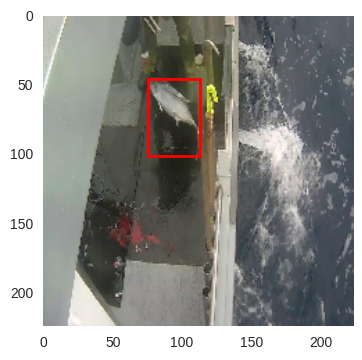

In [16]:
show_bb(1)

##### Define bb models

In [17]:
# vgg = Vgg16(load_weights=True)
vgg = Vgg16(load_weights=False)
layers_conv, layers_fc = utils.split_at(vgg.model, Conv2D)


In [18]:
def gen_bb_max(p, input_shape):
    inp = Input(input_shape)
    x = MaxPooling2D()(inp)
    x = BatchNormalization(axis=3)(x)
    x = Dropout(p/4)(x)
    x = Flatten()(x)
    x = MaxoutDense(256)(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = MaxoutDense(256)(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    out_bb = Dense(4, name='bb')(x)
    out_class = Dense(8, activation='softmax', name='class')(x)
    return models.Model([inp], [out_bb, out_class])

In [19]:
def gen_bb(p, input_shape):
    inp = Input(input_shape)
    x = MaxPooling2D()(inp)
    x = BatchNormalization(axis=3)(x)
    x = Dropout(p/4)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    out_bb = Dense(4, name='bb')(x)
    out_class = Dense(8, activation='softmax', name='class')(x)
    return models.Model([inp], [out_bb, out_class])

#### Maxout bb 

##### Train

In [32]:
model_bb_max = gen_bb_max(0.5, layers_conv[-1].output_shape[1:])
model_bb_max.compile(Adam(lr=1e-2), ['mse', 'categorical_crossentropy'],
                     metrics=['accuracy'], loss_weights=[0.001, 1])

In [34]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_bb_max.{epoch:02d}-{val_class_loss:.3f}'
                        '-{val_class_acc:.3f}.h5',
        save_best_only=True, monitor='val_loss')]
model_bb_max.fit(data_conv_train, [bbox_train, labels_train], batch_size=batch_size,
                 nb_epoch=4,
                 callbacks=callbacks,
                 validation_data=(data_conv_valid, [bbox_valid, labels_valid]))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 56s - loss: 1.2949 - bb_loss: 681.3469 - class_loss: 0.6136 - bb_acc: 0.6788 - class_acc: 0.8415 - val_loss: 2.4020 - val_bb_loss: 782.0193 - val_class_loss: 1.6199 - val_bb_acc: 0.7002 - val_class_acc: 0.7066
Epoch 2/4
467/467 [==============================] - 54s - loss: 1.2513 - bb_loss: 653.4164 - class_loss: 0.5979 - bb_acc: 0.7024 - class_acc: 0.8287 - val_loss: 2.7433 - val_bb_loss: 719.3054 - val_class_loss: 2.0240 - val_bb_acc: 0.6959 - val_class_acc: 0.6788
Epoch 3/4
467/467 [==============================] - 56s - loss: 0.9976 - bb_loss: 644.1559 - class_loss: 0.3535 - bb_acc: 0.6981 - class_acc: 0.8887 - val_loss: 2.0406 - val_bb_loss: 671.4214 - val_class_loss: 1.3691 - val_bb_acc: 0.6788 - val_class_acc: 0.7709
Epoch 4/4
467/467 [==============================] - 54s - loss: 1.0368 - bb_loss: 555.5480 - class_loss: 0.4813 - bb_acc: 0.7195 - class_acc: 0.8587 - val_loss: 2.0

##### Checkpoint

In [15]:
model_fc.load_weights(glob(path_checkpoint+'weights_bb_max.*')[0])

##### Lower lr

In [38]:
K.set_value(model_bb_max.optimizer.lr, 1e-5)

In [40]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_bb_max.{epoch:02d}-{val_class_loss:.3f}'
                        '-{val_class_acc:.3f}.h5',
        save_best_only=True, monitor='val_loss')]
model_bb_max.fit(data_conv_train, [bbox_train, labels_train], batch_size=batch_size,
                 nb_epoch=4,
                 callbacks=callbacks,
                 validation_data=(data_conv_valid, [bbox_valid, labels_valid]))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 56s - loss: 0.7555 - bb_loss: 526.3614 - class_loss: 0.2292 - bb_acc: 0.7666 - class_acc: 0.9079 - val_loss: 1.8084 - val_bb_loss: 637.9736 - val_class_loss: 1.1704 - val_bb_acc: 0.6831 - val_class_acc: 0.7859
Epoch 2/4
467/467 [==============================] - 55s - loss: 0.7924 - bb_loss: 538.6343 - class_loss: 0.2538 - bb_acc: 0.7173 - class_acc: 0.9293 - val_loss: 1.8079 - val_bb_loss: 638.8727 - val_class_loss: 1.1690 - val_bb_acc: 0.6831 - val_class_acc: 0.7859
Epoch 3/4
467/467 [==============================] - 54s - loss: 0.7744 - bb_loss: 527.7284 - class_loss: 0.2467 - bb_acc: 0.7152 - class_acc: 0.9036 - val_loss: 1.8123 - val_bb_loss: 638.3198 - val_class_loss: 1.1740 - val_bb_acc: 0.6809 - val_class_acc: 0.7837
Epoch 4/4
467/467 [==============================] - 56s - loss: 0.7522 - bb_loss: 532.4558 - class_loss: 0.2197 - bb_acc: 0.7152 - class_acc: 0.9315 - val_loss: 1.8

#### Dense bb 

##### Train

In [21]:
model_bb = gen_bb(0.5, layers_conv[-1].output_shape[1:])
model_bb.compile(Adam(lr=1e-2), ['mse', 'categorical_crossentropy'],
                 metrics=['accuracy'], loss_weights=[0.001, 1])

In [24]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_bb.{epoch:02d}-{val_class_loss:.3f}'
                        '-{val_class_acc:.3f}.h5',
        save_best_only=True, monitor='val_loss')]
model_bb.fit(data_conv_train, [bbox_train, labels_train], batch_size=batch_size,
                 nb_epoch=4,
                 callbacks=callbacks,
                 validation_data=(data_conv_valid, [bbox_valid, labels_valid]))

Train on 467 samples, validate on 467 samples
Epoch 1/4
467/467 [==============================] - 18s - loss: 1.6189 - bb_loss: 688.5709 - class_loss: 0.9304 - bb_acc: 0.7216 - class_acc: 0.7859 - val_loss: 2.6615 - val_bb_loss: 699.7332 - val_class_loss: 1.9618 - val_bb_acc: 0.7066 - val_class_acc: 0.6702
Epoch 2/4
467/467 [==============================] - 18s - loss: 1.4644 - bb_loss: 657.3913 - class_loss: 0.8070 - bb_acc: 0.7152 - class_acc: 0.8073 - val_loss: 2.4943 - val_bb_loss: 693.6592 - val_class_loss: 1.8006 - val_bb_acc: 0.7259 - val_class_acc: 0.6981
Epoch 3/4
467/467 [==============================] - 17s - loss: 1.1824 - bb_loss: 618.2586 - class_loss: 0.5642 - bb_acc: 0.7259 - class_acc: 0.8694 - val_loss: 2.9290 - val_bb_loss: 707.2199 - val_class_loss: 2.2218 - val_bb_acc: 0.7002 - val_class_acc: 0.6574
Epoch 4/4
467/467 [==============================] - 18s - loss: 1.2349 - bb_loss: 578.3603 - class_loss: 0.6565 - bb_acc: 0.7323 - class_acc: 0.8522 - val_loss: 2.0

##### Checkpoint

In [15]:
model_fc.load_weights(glob(path_checkpoint+'weights_bb_max.*')[0])

##### Lower lr

In [38]:
K.set_value(model_bb_max.optimizer.lr, 1e-5)

In [26]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_bb.{epoch:02d}-{val_class_loss:.3f}'
                        '-{val_class_acc:.3f}.h5',
        save_best_only=True, monitor='val_loss')]
model_bb.fit(data_conv_train, [bbox_train, labels_train], batch_size=batch_size,
                 nb_epoch=8,
                 callbacks=callbacks,
                 validation_data=(data_conv_valid, [bbox_valid, labels_valid]))

Train on 467 samples, validate on 467 samples
Epoch 1/8
467/467 [==============================] - 20s - loss: 1.1798 - bb_loss: 616.3144 - class_loss: 0.5635 - bb_acc: 0.7195 - class_acc: 0.8779 - val_loss: 2.3107 - val_bb_loss: 636.1619 - val_class_loss: 1.6746 - val_bb_acc: 0.7109 - val_class_acc: 0.7238
Epoch 2/8
467/467 [==============================] - 21s - loss: 1.1181 - bb_loss: 545.5256 - class_loss: 0.5726 - bb_acc: 0.7345 - class_acc: 0.8908 - val_loss: 2.2274 - val_bb_loss: 612.6985 - val_class_loss: 1.6147 - val_bb_acc: 0.7216 - val_class_acc: 0.7366
Epoch 3/8
467/467 [==============================] - 18s - loss: 1.1993 - bb_loss: 563.3214 - class_loss: 0.6360 - bb_acc: 0.7302 - class_acc: 0.8522 - val_loss: 2.5235 - val_bb_loss: 657.0492 - val_class_loss: 1.8664 - val_bb_acc: 0.7323 - val_class_acc: 0.7388
Epoch 4/8
467/467 [==============================] - 16s - loss: 0.9799 - bb_loss: 549.2622 - class_loss: 0.4307 - bb_acc: 0.7045 - class_acc: 0.8844 - val_loss: 2.3

#### Show bb predictions

In [44]:
pred_valid = model_bb_max.predict(data_conv_valid[:10])

In [54]:
def show_bb_pred(i):
    bb = bbox_valid[i]
    bb_pred = pred_valid[0][i]
    sns.plt.figure(figsize=(6,6))
    utils.plot_img(data_valid[i])
    ax=sns.plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

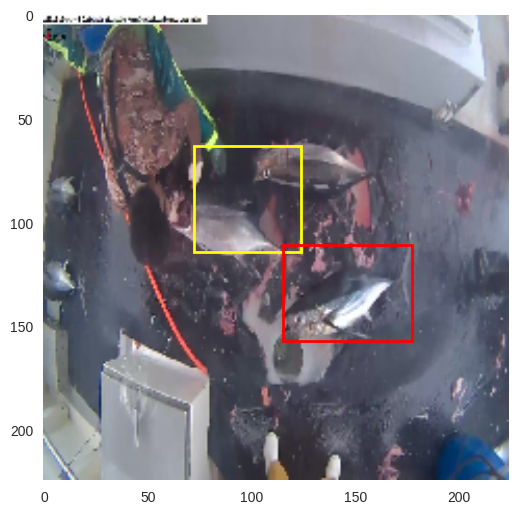

In [61]:
show_bb_pred(8)

## FCN

##### Define Model

In [6]:
vgg = Vgg16(size=(360, 640)).model
vgg.pop()
vgg.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [7]:
layers_conv, _ = utils.split_at(vgg, Convolution2D)

In [11]:
nf = 128
p = 0

In [12]:
def gen_fcn_layers(p):
    return [
        BatchNormalization(axis=3, input_shape=layers_conv[-1].output_shape[1:]),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=3),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=3),
        MaxPooling2D(),
        Convolution2D(nf, 3, 3, activation='relu', border_mode='same'),
        BatchNormalization(axis=3),
        MaxPooling2D((1, 2)),
        Convolution2D(8, 3, 3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [ ]:
model_fcn = models.Sequential(gen_fcn_layers(p))
model_fcn.compile(Adam(lr=1e-2), loss='categorical_crossentropy', metrics=['accuracy'])